Don't allocate all my VRAM

In [1]:
import torch
import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices("GPU")[0], True)  # Don't pre-allocate all my VRAM

Data Loading

In [11]:
from known_vocab.vocab_recognizer import VocabRecognizer
from transformers import BertJapaneseTokenizer
import pandas as pd

# Load known vocab
vocab_recognizer = VocabRecognizer()
bert_tokenizer = BertJapaneseTokenizer.from_pretrained("cl-tohoku/bert-base-japanese",
                                                       word_tokenizer_type="sudachi",
                                                       sudachi_kwargs={
                                                           "sudachi_dict_type": "full",
                                                           "sudachi_split_mode": "A"
                                                       })

# Load sentence difficulty dataset
df = pd.read_csv("./sentence_data/difficulty_日本語.csv")
df = df.sample(frac=1,
               random_state=9)
JAPANESE_SENTENCE_KEY = "日本語"
KNOWN_EMBEDDING_KEY = "Known_Embedding"
DIFFICULTY_KEY = "Difficulty"
df[KNOWN_EMBEDDING_KEY] = df[JAPANESE_SENTENCE_KEY].apply(
    lambda sentence: vocab_recognizer.mark_known_vocab(sentence,
                                                       return_print_str=False,
                                                       sentence_bert_tokenized=bert_tokenizer.tokenize(sentence)))

df[DIFFICULTY_KEY].value_counts()

Difficulty
1    422
2    236
0     14
Name: count, dtype: int64

Clean up Excess Data

In [3]:
# Dataset was mostly Medium level difficulty sentences, remove them to make the dataset more balanced
delete = 1400
deleted = 0
for i, row in df.iterrows():
    if row[DIFFICULTY_KEY] == 1:
        df.drop(i, inplace=True)
        deleted += 1
        if delete == deleted:
            break

df[DIFFICULTY_KEY].value_counts()

Difficulty
1    462
2    437
0    373
Name: count, dtype: int64

Data Splitting

In [4]:
from sklearn.model_selection import train_test_split

# Generate indexes to be set for training and validation
X_train, X_val, y_train, y_val = train_test_split(df.index.values,
                                                  df[DIFFICULTY_KEY].values,
                                                  test_size=0.2,
                                                  shuffle=True,
                                                  stratify=df[DIFFICULTY_KEY].values)
# Set the type of data in the df
df["data_type"] = ["not_set"] * df.shape[0]
df.loc[X_train, "data_type"] = "train"
df.loc[X_val, "data_type"] = "val"

Data Tokenization and Dataset Generation

In [5]:
import numpy as np
from keras.utils.data_utils import pad_sequences
from keras.utils import to_categorical

# Encode the sentences
TOKENIZER_LENGTH = 128
encoded_sentences = bert_tokenizer.batch_encode_plus(df[JAPANESE_SENTENCE_KEY].values,
                                                     add_special_tokens=True,
                                                     return_attention_mask=True,
                                                     padding="max_length",
                                                     max_length=TOKENIZER_LENGTH,
                                                     truncation=True)
df["input_ids"] = encoded_sentences["input_ids"]
df["token_type_ids"] = encoded_sentences["token_type_ids"]
df["attention_mask"] = encoded_sentences["attention_mask"]
df["input_ids"] = df["input_ids"].apply(np.array)
df["token_type_ids"] = df["token_type_ids"].apply(np.array)
df["attention_mask"] = df["attention_mask"].apply(np.array)

# Generate the custom embedding dimension to be appended later (starting and ending 0 for the special tokens)
EMBEDDING_DIM_KEY = "Embedding_Dim"
KNOWN_WEIGHT = 10
UNKNOWN_WEIGHT = -10
df[EMBEDDING_DIM_KEY] = df[KNOWN_EMBEDDING_KEY].apply(
    lambda known_embedding_list:
    pad_sequences([np.array([0] + [KNOWN_WEIGHT if known_embedding else UNKNOWN_WEIGHT for known_embedding in known_embedding_list] + [0])],
                  maxlen=TOKENIZER_LENGTH, dtype=float, padding="post")[0]
)

# Generate one-hot vectors
index2label = {
    0: "Easy",
    1: "Medium",
    2: "Hard"
}
label2index = {
    "Easy": 0,
    "Medium": 1,
    "Hard": 2
}
DIFFICULTY_ONE_HOT_KEY = "Difficulty_OneHot"
df[DIFFICULTY_ONE_HOT_KEY] = df[DIFFICULTY_KEY].apply(
    lambda difficulty: to_categorical(difficulty, num_classes=len(index2label))
)

# Split the dataframe into the train and validation dataframes
train_df = df[df["data_type"] == "train"]
val_df = df[df["data_type"] == "val"]

# Create the TF datasets
train_dataset = tf.data.Dataset.from_tensor_slices(((list(train_df["input_ids"]),
                                                    list(train_df["token_type_ids"]),
                                                    list(train_df["attention_mask"]),
                                                    list(train_df[EMBEDDING_DIM_KEY])),
                                                    list(train_df[DIFFICULTY_ONE_HOT_KEY])))
val_dataset = tf.data.Dataset.from_tensor_slices(((list(val_df["input_ids"]),
                                                  list(val_df["token_type_ids"]),
                                                  list(val_df["attention_mask"]),
                                                  list(val_df[EMBEDDING_DIM_KEY])),
                                                  list(val_df[DIFFICULTY_ONE_HOT_KEY])))

Initialize Model

In [6]:
from transformers import TFBertModel
from keras.layers import Input, Dense, Dropout, Concatenate, LSTM, GlobalAvgPool1D, Bidirectional
from keras.models import Model

bert_model = TFBertModel.from_pretrained("cl-tohoku/bert-base-japanese-v2",
                                         output_attentions=False,
                                         output_hidden_states=False,
                                         trainable=False)

# Inputs to the model, first 3 go to BERT and last is the custom embedding dimension
input_ids = Input(shape=(None, ), dtype=tf.int32, name="input_ids")
token_type_ids = Input(shape=(None, ), dtype=tf.int32, name="token_type_ids")
attention_mask = Input(shape=(None, ), dtype=tf.int32, name="attention_mask")
embedding_dim = Input(shape=(TOKENIZER_LENGTH, ), dtype=tf.float32, name="embedding_dim")


bert_output = bert_model({"input_ids": input_ids, "attention_mask": attention_mask, "token_type_ids": token_type_ids})
o = Concatenate(axis=-1)([bert_output.last_hidden_state, tf.expand_dims(embedding_dim, axis=-1)])
o = Dropout(0.05)(o)
o = Bidirectional(LSTM(units=256, return_sequences=True))(o)
o = Dropout(0.7)(o)
o = Bidirectional(LSTM(units=128, return_sequences=True))(o)
o = Dropout(0.5)(o)
o = GlobalAvgPool1D()(o)
o = Dropout(0.35)(o)
o = Dense(2048)(o)
o = Dropout(0.35)(o)
o = Dense(512)(o)
o = Dropout(0.2)(o)
o = Dense(128)(o)
o = Dropout(0.15)(o)
o = Dense(32)(o)
o = Dense(len(label2index), activation="softmax")(o)
model = Model(inputs=[input_ids, token_type_ids, attention_mask, embedding_dim],
              outputs=o)
model.summary()

Some layers from the model checkpoint at cl-tohoku/bert-base-japanese-v2 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at cl-tohoku/bert-base-japanese-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  111207168   ['attention_mask[0][0]',         
                                thPoolingAndCrossAt               'input_ids[0][0]',          

Train Model

In [7]:
from keras.callbacks import TensorBoard
from keras.metrics import Precision, Recall
from keras.optimizers import Adam

epochs = 100
batch_size = 32
optimizer = Adam(
    learning_rate=1e-6
)
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy", Precision(), Recall()]
)

model_name = "JaVaCE"
history = model.fit(
    train_dataset.batch(batch_size),
    validation_data=val_dataset.batch(batch_size),
    epochs=epochs,
    callbacks=[
        TensorBoard(log_dir=f"./logs/{model_name}/")
    ]
)
model.save(f"./models/{model_name}")

Epoch 1/100
32/32 [==============================] - 19s 237ms/step - loss: 1.1904 - accuracy: 0.3176 - precision: 0.2997 - recall: 0.0875 - val_loss: 1.1113 - val_accuracy: 0.3490 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
32/32 [==============================] - 5s 148ms/step - loss: 1.1689 - accuracy: 0.3235 - precision: 0.3024 - recall: 0.0737 - val_loss: 1.1023 - val_accuracy: 0.3686 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
32/32 [==============================] - 5s 144ms/step - loss: 1.1496 - accuracy: 0.3491 - precision: 0.3563 - recall: 0.0865 - val_loss: 1.0964 - val_accuracy: 0.3765 - val_precision: 0.5000 - val_recall: 0.0039
Epoch 4/100
32/32 [==============================] - 5s 150ms/step - loss: 1.1563 - accuracy: 0.3156 - precision: 0.3211 - recall: 0.0688 - val_loss: 1.0925 - val_accuracy: 0.3647 - val_precision: 1.0000 - val_recall: 0.0039
Epoch 5/100
32/32 [==============================] - 5s 154ms/step - loss: 1.1464 -

INFO:tensorflow:Assets written to: ./models/none\assets


INFO:tensorflow:Assets written to: ./models/none\assets


Training Stats

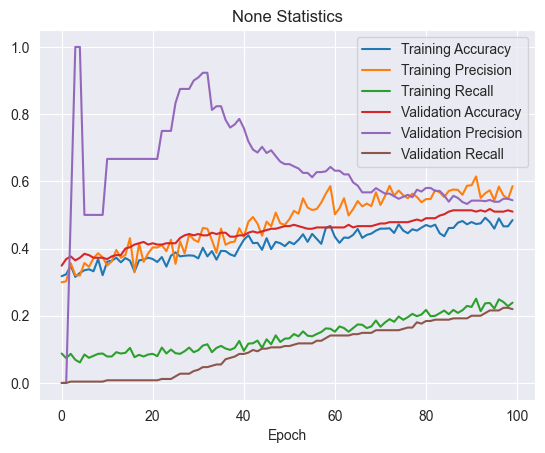

In [8]:
import matplotlib.pyplot as plt
import os
ax = plt.subplot()

# Training Stats
ax.plot(history.history["accuracy"], label="Training Accuracy")
ax.plot(history.history["precision"], label="Training Precision")
ax.plot(history.history["recall"], label="Training Recall")
ax.plot(history.history["val_accuracy"], label="Validation Accuracy")
ax.plot(history.history["val_precision"], label="Validation Precision")
ax.plot(history.history["val_recall"], label="Validation Recall")
ax.set_title("JaVaCE Statistics")
ax.legend(loc="upper right")
ax.set_xlabel("Epoch")

# Validation Stats
plots_dir = f"./plots/{model_name}/"
os.makedirs(plots_dir, exist_ok=True)
plt.savefig(os.path.join(plots_dir, "stats.png"))
plt.show()

Confusion Matrix

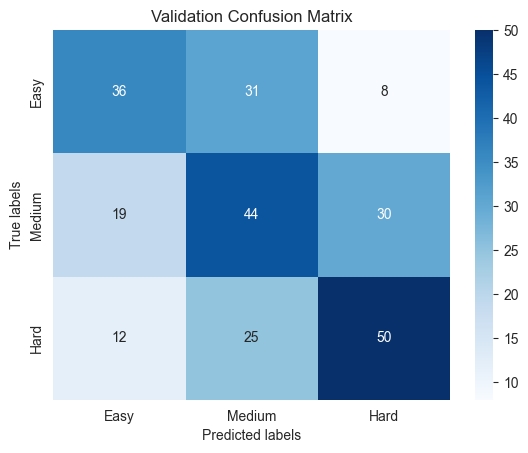

In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true, y_pred = [], []
for batch in val_dataset.batch(batch_size):
    X_batch, y_batch = batch
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(model.predict(X_batch, verbose=0), axis=1))

cm = confusion_matrix(y_true, y_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues')
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Validation Confusion Matrix")
ax.xaxis.set_ticklabels(label2index.keys())
ax.yaxis.set_ticklabels(label2index.keys())
plt.savefig(os.path.join(plots_dir, "cm.png"))
plt.show()